In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import torch
import torchaudio
import seaborn as sns
import helper_functions
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
from sympy import re
import torch.nn as nn
from cv2 import line
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split



In [2]:
data=pd.read_csv('EEG_Eye_State_Classification.csv')

In [3]:
data.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [4]:
eeg_ch=data.drop(columns=['eyeDetection'])
target=data['eyeDetection']

<Axes: >

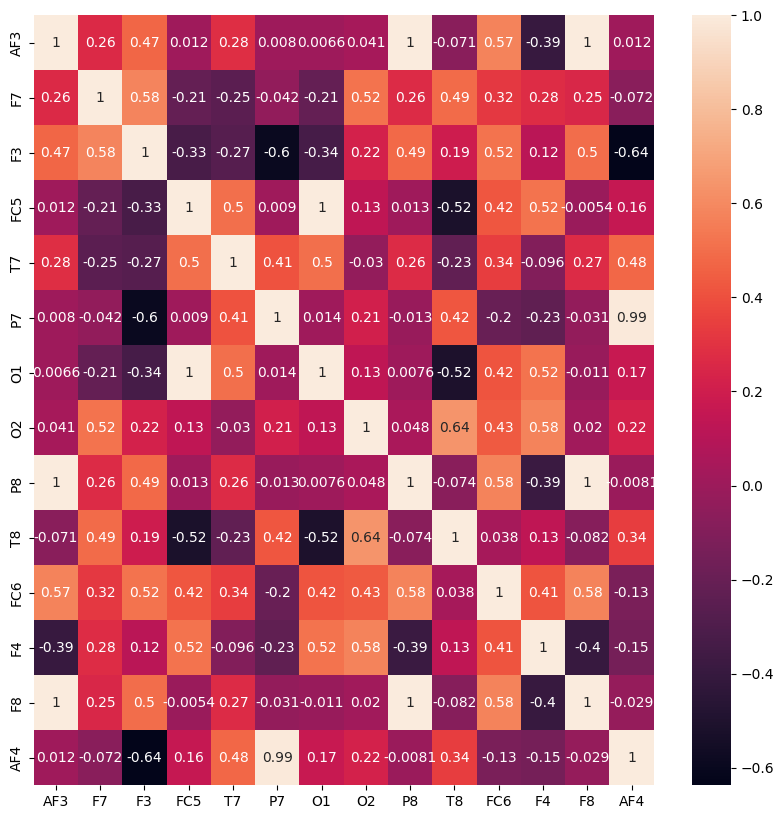

In [5]:
plt.figure(figsize=(10,10))
corr=eeg_ch.corr()

sns.heatmap(corr,annot=True)

**almost identical chaneels**
* F8 &AF3 -->1 .
* F8 & P8 -->1 .
* O1 & FC5-->1 .
* AF3 & P8-->1 .
* p7 & AF4-->0.99

drop AF3 ,F8, O1 ,P7

In [6]:
eeg_ch= eeg_ch.drop(columns=['AF3','F8','O1','P7'])

In [7]:
eeg_ch.shape

(14980, 10)

<Axes: >

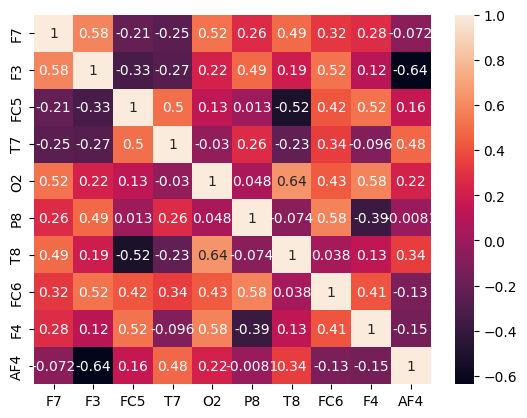

In [8]:
sns.heatmap(eeg_ch.corr(),annot=True)

Normalize


In [9]:
import importlib
importlib.reload(helper_functions)

<module 'helper_functions' from 'c:\\Users\\hana\\OneDrive\\Documents\\GitHub\\EEG-Eye-state-classifier\\helper_functions.py'>

In [10]:
tras=[1,2,3,4,5,10,15,20,50,100]
for t in tras:
    norm_df,droped_count=helper_functions.normalize(eeg_ch,t)
    print(f'{droped_count} values {t} std far from the mean')


6821 values 1 std far from the mean
1387 values 2 std far from the mean
203 values 3 std far from the mean
32 values 4 std far from the mean
31 values 5 std far from the mean
29 values 10 std far from the mean
29 values 15 std far from the mean
27 values 20 std far from the mean
16 values 50 std far from the mean
3 values 100 std far from the mean


**using 4 as a tres**

In [11]:
eeg_norm,droped_count=helper_functions.normalize(eeg_ch,4)
print(f"{droped_count} nan values")

32 nan values


In [12]:
eeg_norm.isna().sum()

F7     4
F3     4
FC5    1
T7     4
O2     4
P8     1
T8     4
FC6    4
F4     4
AF4    2
dtype: int64

In [13]:
eeg_interp = eeg_norm.interpolate(
    method="spline",
    order=3,
    axis=0,
    limit_direction="both"
)


In [14]:
sfreq = 128
t = np.arange(len(eeg_norm)) / sfreq

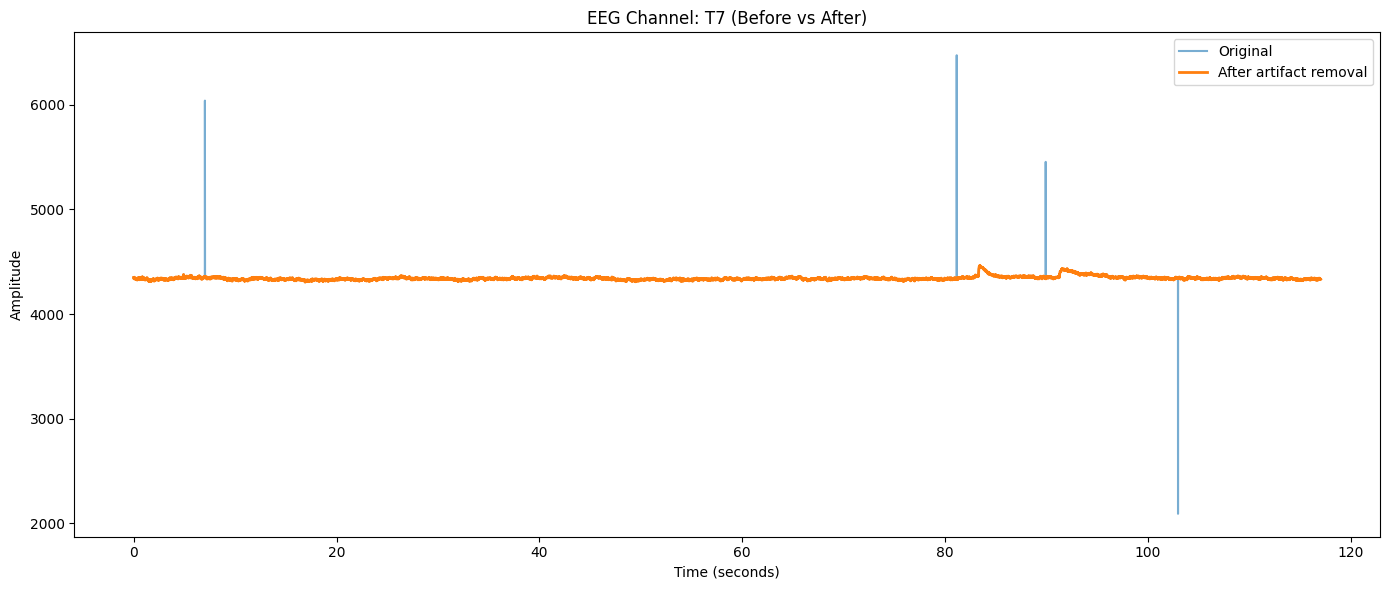

In [15]:
plt.figure(figsize=(14, 6))

# Before
plt.plot(t, eeg_ch['T7'], 
         label="Original", 
         alpha=0.6)

# After
plt.plot(t, eeg_interp['T7'], 
         label="After artifact removal", 
         linewidth=2)

plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title(f"EEG Channel: T7 (Before vs After)")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
importlib.reload(helper_functions)

<module 'helper_functions' from 'c:\\Users\\hana\\OneDrive\\Documents\\GitHub\\EEG-Eye-state-classifier\\helper_functions.py'>

In [17]:
b,a=helper_functions.band_bass(13,8)
eeg_band=pd.DataFrame()
for ch in eeg_interp.columns:

    b_f_eeg=scipy.signal.filtfilt(b,a,eeg_interp[ch])
    eeg_band[ch]=b_f_eeg

In [21]:
eeg_normalized=eeg_band.apply(scipy.stats.zscore)

In [37]:
win_sizes=[1,2,3,4,5]
diffrent_windows={}

for i in win_sizes:
    X_windows ,y_windows=helper_functions.create_windows(eeg_normalized,target,i,0.5)
    diffrent_windows[f"{i} sec windows"]=[X_windows,y_windows]
    print(f"created {X_windows.shape[0]} windows for {i} sec window size")
    # print(y_windows)
    label_zero_count=len([i for i in y_windows if i==0])
    print(f"label distribution of {i} sec window is {label_zero_count} eye closed and {(len(y_windows)-label_zero_count)} eye open")

created 233 windows for 1 sec window size
label distribution of 1 sec window is 129 eye closed and 104 eye open
created 116 windows for 2 sec window size
label distribution of 2 sec window is 65 eye closed and 51 eye open
created 77 windows for 3 sec window size
label distribution of 3 sec window is 43 eye closed and 34 eye open
created 57 windows for 4 sec window size
label distribution of 4 sec window is 30 eye closed and 27 eye open
created 45 windows for 5 sec window size
label distribution of 5 sec window is 25 eye closed and 20 eye open


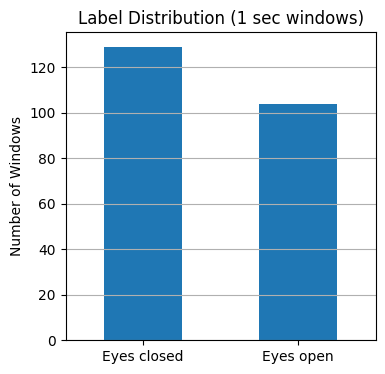

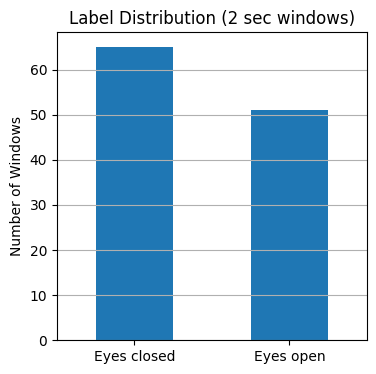

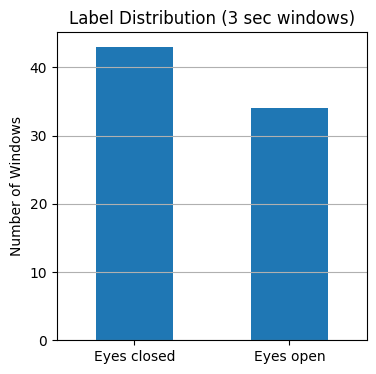

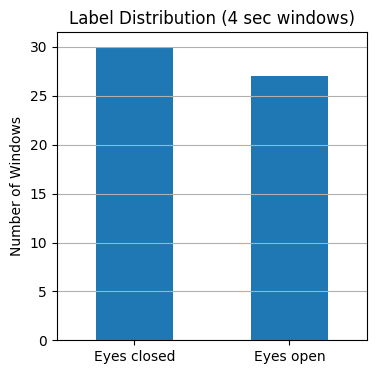

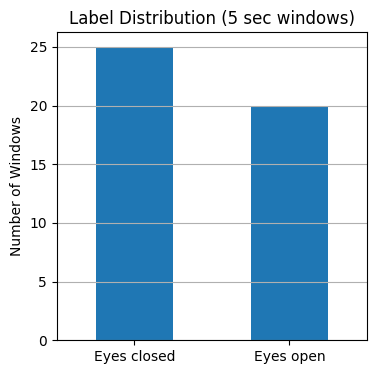

In [38]:
##label distribution
for i in win_sizes:
    
    y=diffrent_windows[f"{i} sec windows"][1]
    label_counts = pd.Series(y).value_counts().sort_index()

    plt.figure(figsize=(4,4))
    label_counts.plot(kind="bar")
    plt.xticks([0,1], ["Eyes closed", "Eyes open"], rotation=0)
    plt.ylabel("Number of Windows")
    plt.title(f"Label Distribution ({i} sec windows)")
    plt.grid(axis="y")
    plt.show()

In [18]:
models = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000),
        {
            "clf__C": [0.01, 0.1, 1, 10]
        }
    ),

    "SVM (RBF)": (
        SVC(kernel="rbf"),
        {
            "clf__C": [0.1, 1, 10],
            "clf__gamma": ["scale", 0.01, 0.1]
        }
    ),

    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20]
        }
    ),

    "KNN": (
        KNeighborsClassifier(),
        {
            "clf__n_neighbors": [3, 5, 7, 9]
        }
    )
}


In [19]:
def evaluate_models(X, y, models):
    results = {}

    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for name, (model, param_grid) in models.items():

        fold_accuracies = []
        best_params_per_fold = []

        for train_idx, test_idx in cv_outer.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            pipeline = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", model)
            ])

            grid = GridSearchCV(
                pipeline,
                param_grid,
                cv=3,
                scoring="accuracy",
                n_jobs=-1
            )

            grid.fit(X_train, y_train)

            y_pred = grid.predict(X_test)
            acc = accuracy_score(y_test, y_pred)

            fold_accuracies.append(acc)
            best_params_per_fold.append(grid.best_params_)

        results[name] = {
            "fold_accuracies": fold_accuracies,
            "mean_accuracy": np.mean(fold_accuracies),
            "std_accuracy": np.std(fold_accuracies),
            "best_params": best_params_per_fold
        }

        print(
            f"{name}: "
            f"{np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}"
        )

    return results


In [25]:
channel_names=eeg_normalized.columns
channel_names

Index(['F7', 'F3', 'FC5', 'T7', 'O2', 'P8', 'T8', 'FC6', 'F4', 'AF4'], dtype='object')

In [ ]:
#0.5 overlap
#best acc KNN: 0.6900 ± 0.1453
window_sizes = [1, 2, 3, 4, 5]
# sfreq = 128

all_results = {}

for win_sec in window_sizes:
    print(f"\n=== Window size: {win_sec} sec ===")

    X_windows, y_windows = diffrent_windows[f"{win_sec} sec windows"]

    X_features = helper_functions.features_all_windows(
        X_windows,
        channel_names,
        sfreq
    )

    # Convert to numpy for sklearn indexing
    X_features = X_features.values
    y_windows = np.array(y_windows)

    results = evaluate_models(X_features, y_windows, models)

    all_results[win_sec] = results



=== Window size: 1 sec ===
Logistic Regression: 0.6259 ± 0.0516
SVM (RBF): 0.5538 ± 0.0150
Random Forest: 0.5803 ± 0.1065
KNN: 0.5795 ± 0.1373

=== Window size: 2 sec ===
Logistic Regression: 0.6636 ± 0.1191
SVM (RBF): 0.5598 ± 0.0268
Random Forest: 0.6106 ± 0.1330
KNN: 0.5848 ± 0.0985

=== Window size: 3 sec ===
Logistic Regression: 0.5946 ± 0.1451
SVM (RBF): 0.5893 ± 0.1388
Random Forest: 0.5929 ± 0.1585
KNN: 0.6089 ± 0.1311

=== Window size: 4 sec ===
Logistic Regression: 0.6267 ± 0.1323
SVM (RBF): 0.5833 ± 0.1621
Random Forest: 0.5633 ± 0.1456
KNN: 0.6900 ± 0.1453

=== Window size: 5 sec ===
Logistic Regression: 0.5950 ± 0.1753
SVM (RBF): 0.5500 ± 0.0500
Random Forest: 0.6250 ± 0.1792
KNN: 0.6050 ± 0.2138


In [59]:
features_diff = {}

for win_size, (X_windows, y_windows) in diffrent_windows.items():
    
    X_windows_numeric = [np.array(w) if not isinstance(w, np.ndarray) else w for w in X_windows]

    X_features = helper_functions.features_all_windows(
        X_windows_numeric,
        channel_names,
        sfreq
    )

    features_diff[f"{win_size}  features"] = (X_features , y_windows)


In [67]:
window_sizes = [1, 2, 3, 4, 5]
all_results = {}

for win_sec in window_sizes:
    key = f"{win_sec} sec windows  features"  
    print(f"\n=== Window size: {win_sec} sec ===")

    # Get features and labels from the dictionary
    X_features, y_windows = features_diff[key]

    # Convert to numpy arrays for sklearn
    X_features = X_features.values if isinstance(X_features, pd.DataFrame) else np.array(X_features)
    y_windows = np.array(y_windows)

    # Evaluate models
    results = evaluate_models(X_features, y_windows, models)

    all_results[win_sec] = results



=== Window size: 1 sec ===
Logistic Regression: 0.6259 ± 0.0516
SVM (RBF): 0.5538 ± 0.0150
Random Forest: 0.5803 ± 0.1065
KNN: 0.5795 ± 0.1373

=== Window size: 2 sec ===
Logistic Regression: 0.6636 ± 0.1191
SVM (RBF): 0.5598 ± 0.0268
Random Forest: 0.6106 ± 0.1330
KNN: 0.5848 ± 0.0985

=== Window size: 3 sec ===
Logistic Regression: 0.5946 ± 0.1451
SVM (RBF): 0.5893 ± 0.1388
Random Forest: 0.5929 ± 0.1585
KNN: 0.6089 ± 0.1311

=== Window size: 4 sec ===
Logistic Regression: 0.6267 ± 0.1323
SVM (RBF): 0.5833 ± 0.1621
Random Forest: 0.5633 ± 0.1456
KNN: 0.6900 ± 0.1453

=== Window size: 5 sec ===
Logistic Regression: 0.5950 ± 0.1753
SVM (RBF): 0.5500 ± 0.0500
Random Forest: 0.6250 ± 0.1792
KNN: 0.6050 ± 0.2138


try diffrent overlaps

In [74]:
win_sizes=[1,2,3,4,5]
diffrent_windows_03OVL={}

for i in win_sizes:
    X_windows ,y_windows=helper_functions.create_windows(eeg_normalized,target,i,0.3)
    diffrent_windows_03OVL[f"{i} sec windows"]=[X_windows,y_windows]
    print(f"created {X_windows.shape[0]} windows for {i} sec window size")
    # print(y_windows)
    label_zero_count=len([i for i in y_windows if i==0])
    print(f"label distribution of {i} sec window is {label_zero_count} eye closed and {(len(y_windows)-label_zero_count)} eye open")

created 167 windows for 1 sec window size
label distribution of 1 sec window is 95 eye closed and 72 eye open
created 83 windows for 2 sec window size
label distribution of 2 sec window is 47 eye closed and 36 eye open
created 55 windows for 3 sec window size
label distribution of 3 sec window is 29 eye closed and 26 eye open
created 41 windows for 4 sec window size
label distribution of 4 sec window is 23 eye closed and 18 eye open
created 33 windows for 5 sec window size
label distribution of 5 sec window is 18 eye closed and 15 eye open


In [ ]:
#0.3 overlap
#best acc KNN: 0.7750 ± 0 , SVM (RBF): 0.7000 ± 0.1871

window_sizes = [1, 2, 3, 4, 5]
# sfreq = 128

all_results = {}

for win_sec in window_sizes:
    print(f"\n=== Window size: {win_sec} sec ===")

    X_windows, y_windows = diffrent_windows_03OVL[f"{win_sec} sec windows"]

    X_features = helper_functions.features_all_windows(
        X_windows,
        channel_names,
        sfreq
    )

    # Convert to numpy for sklearn indexing
    X_features = X_features.values
    y_windows = np.array(y_windows)

    results = evaluate_models(X_features, y_windows, models)

    all_results[win_sec] = results



=== Window size: 1 sec ===
Logistic Regression: 0.5699 ± 0.0630
SVM (RBF): 0.5687 ± 0.0226
Random Forest: 0.5460 ± 0.0796
KNN: 0.5699 ± 0.1134

=== Window size: 2 sec ===
Logistic Regression: 0.6014 ± 0.1505
SVM (RBF): 0.5667 ± 0.0523
Random Forest: 0.6514 ± 0.1229
KNN: 0.5792 ± 0.1434

=== Window size: 3 sec ===
Logistic Regression: 0.5900 ± 0.1647
SVM (RBF): 0.4900 ± 0.1136
Random Forest: 0.4667 ± 0.1422
KNN: 0.5033 ± 0.1027

=== Window size: 4 sec ===
Logistic Regression: 0.6500 ± 0.2000
SVM (RBF): 0.7000 ± 0.1871
Random Forest: 0.6600 ± 0.1594
KNN: 0.7750 ± 0.1750

=== Window size: 5 sec ===
Logistic Regression: 0.5833 ± 0.2635
SVM (RBF): 0.5667 ± 0.1658
Random Forest: 0.4833 ± 0.2759
KNN: 0.4167 ± 0.2635


In [ ]:
win_sizes=[1,2,3,4,5]
diffrent_windows_NoOVL={}

for i in win_sizes:
    X_windows ,y_windows=helper_functions.create_windows(eeg_normalized,target,i,1)
    diffrent_windows_NoOVL[f"{i} sec windows"]=[X_windows,y_windows]
    print(f"created {X_windows.shape[0]} windows for {i} sec window size")
    # print(y_windows)
    label_zero_count=len([i for i in y_windows if i==0])
    print(f"label distribution of {i} sec window is {label_zero_count} eye closed and {(len(y_windows)-label_zero_count)} eye open")

In [ ]:
#no overlap
#best acc KNN: 0.6900 ± 0.1453
window_sizes = [1, 2, 3, 4, 5]
# sfreq = 128

all_results = {}

for win_sec in window_sizes:
    print(f"\n=== Window size: {win_sec} sec ===")

    X_windows, y_windows = diffrent_windows_NoOVL[f"{win_sec} sec windows"]

    X_features = helper_functions.features_all_windows(
        X_windows,
        channel_names,
        sfreq
    )

    # Convert to numpy for sklearn indexing
    X_features = X_features.values
    y_windows = np.array(y_windows)

    results = evaluate_models(X_features, y_windows, models)

    all_results[win_sec] = results



=== Window size: 1 sec ===
Logistic Regression: 0.6259 ± 0.0516
SVM (RBF): 0.5538 ± 0.0150
Random Forest: 0.5803 ± 0.1065
KNN: 0.5795 ± 0.1373

=== Window size: 2 sec ===
Logistic Regression: 0.6636 ± 0.1191
SVM (RBF): 0.5598 ± 0.0268
Random Forest: 0.6106 ± 0.1330
KNN: 0.5848 ± 0.0985

=== Window size: 3 sec ===
Logistic Regression: 0.5946 ± 0.1451
SVM (RBF): 0.5893 ± 0.1388
Random Forest: 0.5929 ± 0.1585
KNN: 0.6089 ± 0.1311

=== Window size: 4 sec ===
Logistic Regression: 0.6267 ± 0.1323
SVM (RBF): 0.5833 ± 0.1621
Random Forest: 0.5633 ± 0.1456
KNN: 0.6900 ± 0.1453

=== Window size: 5 sec ===
Logistic Regression: 0.5950 ± 0.1753
SVM (RBF): 0.5500 ± 0.0500
Random Forest: 0.6250 ± 0.1792
KNN: 0.6050 ± 0.2138


In [23]:
win_sizes=[1,2,3,4,5]
diffrent_windows_07OVL={}

for i in win_sizes:
    X_windows ,y_windows=helper_functions.create_windows(eeg_normalized,target,i,0.7)
    diffrent_windows_07OVL[f"{i} sec windows"]=[X_windows,y_windows]
    print(f"created {X_windows.shape[0]} windows for {i} sec window size")
    # print(y_windows)
    label_zero_count=len([i for i in y_windows if i==0])
    print(f"label distribution of {i} sec window is {label_zero_count} eye closed and {(len(y_windows)-label_zero_count)} eye open")

created 391 windows for 1 sec window size
label distribution of 1 sec window is 218 eye closed and 173 eye open
created 194 windows for 2 sec window size
label distribution of 2 sec window is 108 eye closed and 86 eye open
created 127 windows for 3 sec window size
label distribution of 3 sec window is 69 eye closed and 58 eye open
created 95 windows for 4 sec window size
label distribution of 4 sec window is 51 eye closed and 44 eye open
created 75 windows for 5 sec window size
label distribution of 5 sec window is 41 eye closed and 34 eye open


In [ ]:
#0.7 overlap
#best acc Random Forest: 0.7571 ± 0.1651
window_sizes = [1, 2, 3, 4, 5]
# sfreq = 128

all_results = {}

for win_sec in window_sizes:
    print(f"\n=== Window size: {win_sec} sec ===")

    X_windows, y_windows = diffrent_windows_07OVL[f"{win_sec} sec windows"]

    X_features = helper_functions.features_all_windows(
        X_windows,
        channel_names,
        sfreq
    )

    # Convert to numpy for sklearn indexing
    X_features = X_features.values
    y_windows = np.array(y_windows)

    results = evaluate_models(X_features, y_windows, models)

    all_results[win_sec] = results



=== Window size: 1 sec ===
Logistic Regression: 0.6624 ± 0.0760
SVM (RBF): 0.5576 ± 0.0104
Random Forest: 0.6750 ± 0.0666
KNN: 0.7108 ± 0.0684

=== Window size: 2 sec ===
Logistic Regression: 0.6995 ± 0.1063
SVM (RBF): 0.5568 ± 0.0200
Random Forest: 0.7529 ± 0.0848
KNN: 0.7268 ± 0.1193

=== Window size: 3 sec ===
Logistic Regression: 0.6853 ± 0.1476
SVM (RBF): 0.5436 ± 0.0229
Random Forest: 0.7231 ± 0.0845
KNN: 0.6141 ± 0.1037

=== Window size: 4 sec ===
Logistic Regression: 0.7267 ± 0.1521
SVM (RBF): 0.6300 ± 0.1205
Random Forest: 0.7056 ± 0.1894
KNN: 0.7144 ± 0.0965

=== Window size: 5 sec ===
Logistic Regression: 0.7429 ± 0.1308
SVM (RBF): 0.6571 ± 0.1485
Random Forest: 0.7571 ± 0.1651
KNN: 0.6232 ± 0.1342


In [27]:
win_sizes=[1,2,3,4,5]
diffrent_windows_01OVL={}

for i in win_sizes:
    X_windows ,y_windows=helper_functions.create_windows(eeg_normalized,target,i,0.1)
    diffrent_windows_01OVL[f"{i} sec windows"]=[X_windows,y_windows]
    print(f"created {X_windows.shape[0]} windows for {i} sec window size")
    # print(y_windows)
    label_zero_count=len([i for i in y_windows if i==0])
    print(f"label distribution of {i} sec window is {label_zero_count} eye closed and {(len(y_windows)-label_zero_count)} eye open")

created 130 windows for 1 sec window size
label distribution of 1 sec window is 75 eye closed and 55 eye open
created 65 windows for 2 sec window size
label distribution of 2 sec window is 37 eye closed and 28 eye open
created 43 windows for 3 sec window size
label distribution of 3 sec window is 23 eye closed and 20 eye open
created 32 windows for 4 sec window size
label distribution of 4 sec window is 16 eye closed and 16 eye open
created 25 windows for 5 sec window size
label distribution of 5 sec window is 13 eye closed and 12 eye open


In [28]:
#no overlap
#best acc KNN: 0.6900 ± 0.1453
window_sizes = [1, 2, 3, 4, 5]
# sfreq = 128

all_results = {}

for win_sec in window_sizes:
    print(f"\n=== Window size: {win_sec} sec ===")

    X_windows, y_windows = diffrent_windows_07OVL[f"{win_sec} sec windows"]

    X_features = helper_functions.features_all_windows(
        X_windows,
        channel_names,
        sfreq
    )

    # Convert to numpy for sklearn indexing
    X_features = X_features.values
    y_windows = np.array(y_windows)

    results = evaluate_models(X_features, y_windows, models)

    all_results[win_sec] = results



=== Window size: 1 sec ===
Logistic Regression: 0.6624 ± 0.0760
SVM (RBF): 0.5576 ± 0.0104
Random Forest: 0.6750 ± 0.0666
KNN: 0.7108 ± 0.0684

=== Window size: 2 sec ===
Logistic Regression: 0.6995 ± 0.1063
SVM (RBF): 0.5568 ± 0.0200
Random Forest: 0.7529 ± 0.0848
KNN: 0.7268 ± 0.1193

=== Window size: 3 sec ===
Logistic Regression: 0.6853 ± 0.1476
SVM (RBF): 0.5436 ± 0.0229
Random Forest: 0.7231 ± 0.0845
KNN: 0.6141 ± 0.1037

=== Window size: 4 sec ===
Logistic Regression: 0.7267 ± 0.1521
SVM (RBF): 0.6300 ± 0.1205
Random Forest: 0.7056 ± 0.1894
KNN: 0.7144 ± 0.0965

=== Window size: 5 sec ===
Logistic Regression: 0.7429 ± 0.1308
SVM (RBF): 0.6571 ± 0.1485
Random Forest: 0.7571 ± 0.1651
KNN: 0.6232 ± 0.1342


## Deep learning

In [31]:
importlib.reload(helper_functions)

<module 'helper_functions' from 'c:\\Users\\hana\\OneDrive\\Documents\\GitHub\\EEG-Eye-state-classifier\\helper_functions.py'>

In [ ]:
device= 'cuda'
batch_size=16
# criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [40]:
class BiLSTM(nn.Module):
    def __init__(self, n_channels, hidden_size,dropout=0.3):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=n_channels,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # x: (batch, seq_len, channels)
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out)  # (batch, seq_len, 1)
        return out


In [41]:
class CNN_BiLSTM(nn.Module):
    def __init__(self, n_channels):
        super().__init__()

        self.conv1 = nn.Conv1d(n_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)

        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=64,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64 * 2, 1)

    def forward(self, x):
        # x: (batch, seq, channels)
        x = x.permute(0, 2, 1)        # (batch, channels, seq)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))

        x = x.permute(0, 2, 1)        # (batch, seq, features)

        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out)
        return out


In [32]:
def train_model(model, train_loader, val_loader,criterion,optimizer, epochs=70, patience=20):
    best_loss = np.inf
    patience_counter = 0

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            optimizer.zero_grad()
            outputs = model(Xb).squeeze(-1)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                outputs = model(Xb).squeeze(-1)
                loss = criterion(outputs, yb)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: train={train_loss:.4f}, val={val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model=model
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    return best_model,train_losses, val_losses


In [55]:
def evaluate(model, test_loader):
    model.eval()

    all_preds = []
    all_true = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)          # (B, T, 1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long() # (B, T, 1)

            preds = preds.squeeze(-1)         # ✅ (B, T)
            y_batch = y_batch.long()          # ensure integer labels

            all_preds.append(preds.cpu())
            all_true.append(y_batch.cpu())

    y_pred_flat = torch.cat(all_preds).reshape(-1).numpy()
    y_true_flat = torch.cat(all_true).reshape(-1).numpy()

    return y_true_flat, y_pred_flat


In [33]:
importlib.reload(helper_functions)

<module 'helper_functions' from 'c:\\Users\\hana\\OneDrive\\Documents\\GitHub\\EEG-Eye-state-classifier\\helper_functions.py'>

In [45]:
X_seq_NoOVL,y_seq_NoOVL=helper_functions.create_sequences(eeg_normalized,target,128)
print(X_seq_NoOVL.shape)
print(y_seq_NoOVL.shape)

X_train_NoOVL,X_test_NoOVL,y_train_NoOVL,y_test_NoOVL=train_test_split(X_seq_NoOVL,
                                                                   y_seq_NoOVL,
                                                                   test_size=0.2,
                                                                   random_state=42,
                                                                   stratify=y_seq_NoOVL[:, 0])

train_loader_NoOVL=DataLoader(
    TensorDataset(X_train_NoOVL, y_train_NoOVL),
    batch_size=batch_size,
    shuffle=True
)

test_loader_NoOVL=DataLoader(
    TensorDataset(X_test_NoOVL,y_test_NoOVL),
    batch_size=batch_size,
    shuffle=True
)

torch.Size([117, 128, 10])
torch.Size([117, 128])


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTM(n_channels=10, hidden_size=64).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)


In [58]:
best_model_NoOVL,train_losses_NoOVL, val_losses_NoOVL = train_model(
    model,
    train_loader_NoOVL,
    test_loader_NoOVL,
    criterion,
    optimizer,
    1000,
    100
)


Epoch 1: train=0.6936, val=0.6942
Epoch 2: train=0.6939, val=0.6945
Epoch 3: train=0.6935, val=0.6937
Epoch 4: train=0.6934, val=0.6946
Epoch 5: train=0.6936, val=0.6940
Epoch 6: train=0.6933, val=0.6943
Epoch 7: train=0.6935, val=0.6943
Epoch 8: train=0.6932, val=0.6942
Epoch 9: train=0.6936, val=0.6946
Epoch 10: train=0.6933, val=0.6939
Epoch 11: train=0.6932, val=0.6943
Epoch 12: train=0.6932, val=0.6944
Epoch 13: train=0.6931, val=0.6939
Epoch 14: train=0.6931, val=0.6940
Epoch 15: train=0.6934, val=0.6945
Epoch 16: train=0.6933, val=0.6943
Epoch 17: train=0.6932, val=0.6943
Epoch 18: train=0.6933, val=0.6938
Epoch 19: train=0.6934, val=0.6940
Epoch 20: train=0.6933, val=0.6941
Epoch 21: train=0.6931, val=0.6940
Epoch 22: train=0.6934, val=0.6942
Epoch 23: train=0.6932, val=0.6938
Epoch 24: train=0.6933, val=0.6938
Epoch 25: train=0.6932, val=0.6942
Epoch 26: train=0.6933, val=0.6937
Epoch 27: train=0.6930, val=0.6938
Epoch 28: train=0.6932, val=0.6938
Epoch 29: train=0.6928, val=0

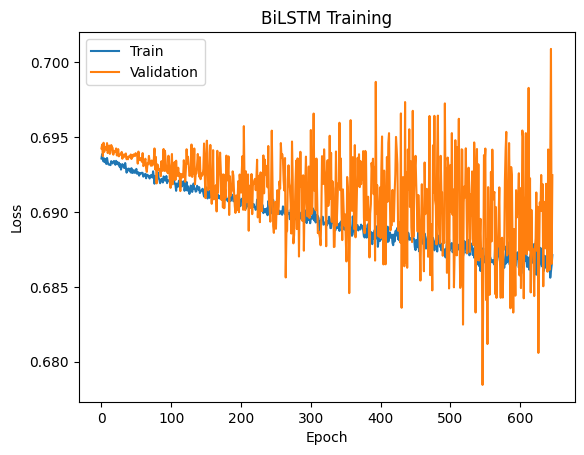

In [59]:
plt.plot(train_losses_NoOVL, label="Train")
plt.plot(val_losses_NoOVL, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [60]:
y_true_flat,y_pred_flat=evaluate(best_model_NoOVL,test_loader_NoOVL)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.55      0.98      0.71      1716
   Eyes open       0.21      0.01      0.02      1356

    accuracy                           0.55      3072
   macro avg       0.38      0.49      0.36      3072
weighted avg       0.40      0.55      0.40      3072



## 0.5 overlap

In [ ]:

X_seq_05OVL,y_seq_05OVL=helper_functions.create_sequences(eeg_normalized,target,128,0.5)
print(X_seq_05OVL.shape)
print(y_seq_05OVL.shape)

X_train_05OVL,X_test_05OVL,y_train_05OVL,y_test_05OVL=train_test_split(X_seq_05OVL,
                                                                   y_seq_05OVL,
                                                                   test_size=0.2,
                                                                   random_state=42,
                                                                   stratify=y_seq_05OVL[:, 0])

train_loader_05OVL=DataLoader(
    TensorDataset(X_train_05OVL, y_train_05OVL),
    batch_size=batch_size,
    shuffle=True
)

test_loader_05OVL=DataLoader(
    TensorDataset(X_test_05OVL,y_test_05OVL),
    batch_size=batch_size,
    shuffle=True
)

torch.Size([233, 128, 10])
torch.Size([233, 128])


In [73]:
model = BiLSTM(n_channels=10, hidden_size=64).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
best_model_05OVL,train_losses_05OVL, val_losses_05OVL = train_model(
    model,
    train_loader_05OVL,
    test_loader_05OVL,
    criterion,
    optimizer,
    1000,
    100
)


Epoch 1: train=0.6922, val=0.6914
Epoch 2: train=0.6920, val=0.6914
Epoch 3: train=0.6915, val=0.6913
Epoch 4: train=0.6922, val=0.6912
Epoch 5: train=0.6921, val=0.6913
Epoch 6: train=0.6921, val=0.6911
Epoch 7: train=0.6925, val=0.6911
Epoch 8: train=0.6918, val=0.6909
Epoch 9: train=0.6919, val=0.6909
Epoch 10: train=0.6918, val=0.6908
Epoch 11: train=0.6915, val=0.6909
Epoch 12: train=0.6918, val=0.6908
Epoch 13: train=0.6919, val=0.6906
Epoch 14: train=0.6916, val=0.6910
Epoch 15: train=0.6910, val=0.6905
Epoch 16: train=0.6912, val=0.6905
Epoch 17: train=0.6913, val=0.6906
Epoch 18: train=0.6912, val=0.6905
Epoch 19: train=0.6920, val=0.6906
Epoch 20: train=0.6910, val=0.6905
Epoch 21: train=0.6913, val=0.6904
Epoch 22: train=0.6910, val=0.6903
Epoch 23: train=0.6912, val=0.6903
Epoch 24: train=0.6910, val=0.6904
Epoch 25: train=0.6911, val=0.6902
Epoch 26: train=0.6910, val=0.6901
Epoch 27: train=0.6909, val=0.6902
Epoch 28: train=0.6908, val=0.6900
Epoch 29: train=0.6910, val=0

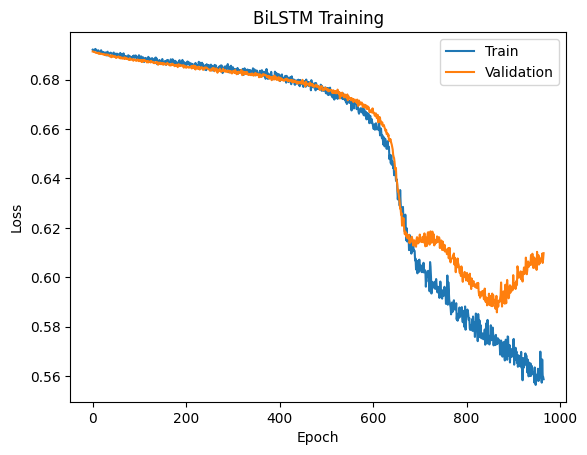

In [74]:
plt.plot(train_losses_05OVL, label="Train")
plt.plot(val_losses_05OVL, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [75]:
y_true_flat,y_pred_flat=evaluate(best_model_05OVL,test_loader_05OVL)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.67      0.77      0.72      3361
   Eyes open       0.64      0.51      0.57      2655

    accuracy                           0.66      6016
   macro avg       0.65      0.64      0.64      6016
weighted avg       0.65      0.66      0.65      6016



In [68]:
def create_loader(df=eeg_normalized,target=target,seq_len=128,overlap=1):
    
    X_seq,y_seq=helper_functions.create_sequences(eeg_normalized,target,seq_len,overlap)
    print(X_seq.shape)
    print(y_seq.shape)

    X_train,X_test,y_train,y_test=train_test_split(X_seq,
                                                                    y_seq,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=y_seq[:, 0])

    train_loader=DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )

    test_loader=DataLoader(
        TensorDataset(X_test,y_test),
        batch_size=batch_size,
        shuffle=True
    )
    return train_loader,test_loader

In [69]:
train_loader_03OVL,test_loader_03OVL= create_loader(eeg_normalized,target,128,0.3)

torch.Size([391, 128, 10])
torch.Size([391, 128])


In [76]:
best_model_03OVL,train_losses_03OVL, val_losses_03OVL = train_model(
    model,
    train_loader_NoOVL,
    test_loader_NoOVL,
    criterion,
    optimizer,
    1000,
    100
)


Epoch 1: train=0.5583, val=0.5494
Epoch 2: train=0.5604, val=0.5233
Epoch 3: train=0.5607, val=0.5383
Epoch 4: train=0.5706, val=0.5406
Epoch 5: train=0.5629, val=0.5364
Epoch 6: train=0.5591, val=0.5633
Epoch 7: train=0.5580, val=0.5563
Epoch 8: train=0.5563, val=0.5667
Epoch 9: train=0.5617, val=0.5585
Epoch 10: train=0.5589, val=0.5099
Epoch 11: train=0.5560, val=0.5937
Epoch 12: train=0.5588, val=0.5692
Epoch 13: train=0.5571, val=0.5225
Epoch 14: train=0.5539, val=0.5490
Epoch 15: train=0.5553, val=0.5589
Epoch 16: train=0.5522, val=0.5338
Epoch 17: train=0.5524, val=0.5910
Epoch 18: train=0.5529, val=0.5458
Epoch 19: train=0.5468, val=0.5881
Epoch 20: train=0.5468, val=0.5549
Epoch 21: train=0.5433, val=0.5509
Epoch 22: train=0.5453, val=0.5525
Epoch 23: train=0.5445, val=0.5866
Epoch 24: train=0.5486, val=0.5704
Epoch 25: train=0.5468, val=0.5921
Epoch 26: train=0.5416, val=0.5728
Epoch 27: train=0.5472, val=0.5741
Epoch 28: train=0.5454, val=0.5323
Epoch 29: train=0.5444, val=0

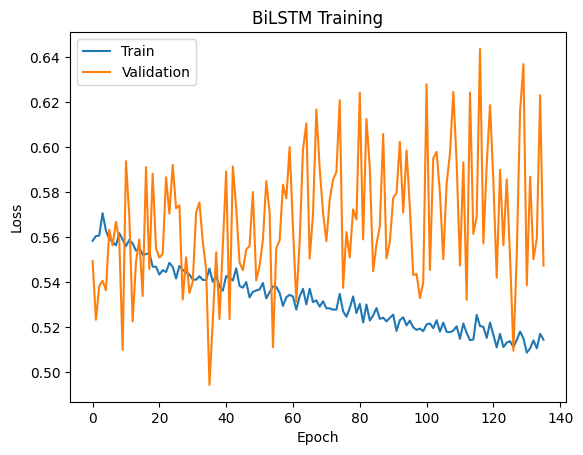

In [77]:
plt.plot(train_losses_03OVL, label="Train")
plt.plot(val_losses_03OVL, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [78]:
y_true_flat,y_pred_flat=evaluate(best_model_03OVL,test_loader_03OVL)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.76      0.70      0.73      5721
   Eyes open       0.64      0.71      0.67      4391

    accuracy                           0.70     10112
   macro avg       0.70      0.70      0.70     10112
weighted avg       0.71      0.70      0.70     10112



In [79]:
train_loader_01OVL,test_loader_01OVL= create_loader(eeg_normalized,target,128,0.1)

torch.Size([1238, 128, 10])
torch.Size([1238, 128])


In [80]:
model = BiLSTM(n_channels=10, hidden_size=64).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
best_model_01OVL,train_losses_01OVL, val_losses_01OVL = train_model(
    model,
    train_loader_01OVL,
    test_loader_01OVL,
    criterion,
    optimizer,
    1000,
    100
)


Epoch 1: train=0.6909, val=0.6906
Epoch 2: train=0.6907, val=0.6909
Epoch 3: train=0.6906, val=0.6909
Epoch 4: train=0.6904, val=0.6900
Epoch 5: train=0.6902, val=0.6909
Epoch 6: train=0.6899, val=0.6907
Epoch 7: train=0.6899, val=0.6895
Epoch 8: train=0.6898, val=0.6900
Epoch 9: train=0.6897, val=0.6900
Epoch 10: train=0.6894, val=0.6900
Epoch 11: train=0.6893, val=0.6904
Epoch 12: train=0.6891, val=0.6892
Epoch 13: train=0.6891, val=0.6891
Epoch 14: train=0.6890, val=0.6889
Epoch 15: train=0.6888, val=0.6894
Epoch 16: train=0.6887, val=0.6896
Epoch 17: train=0.6885, val=0.6881
Epoch 18: train=0.6885, val=0.6893
Epoch 19: train=0.6883, val=0.6881
Epoch 20: train=0.6881, val=0.6886
Epoch 21: train=0.6881, val=0.6873
Epoch 22: train=0.6880, val=0.6892
Epoch 23: train=0.6878, val=0.6871
Epoch 24: train=0.6877, val=0.6877
Epoch 25: train=0.6876, val=0.6881
Epoch 26: train=0.6876, val=0.6876
Epoch 27: train=0.6874, val=0.6874
Epoch 28: train=0.6873, val=0.6858
Epoch 29: train=0.6872, val=0

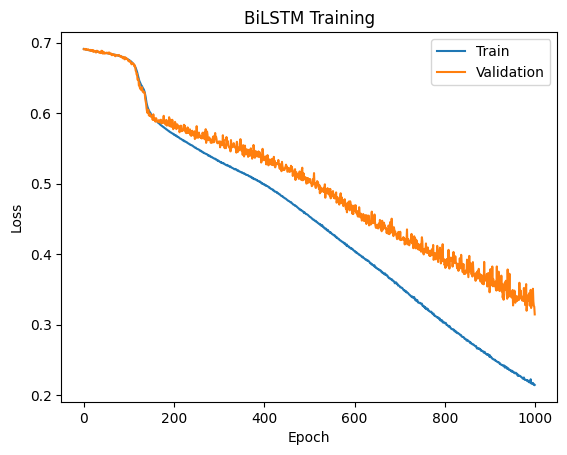

In [81]:
plt.plot(train_losses_01OVL, label="Train")
plt.plot(val_losses_01OVL, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [82]:
y_true_flat,y_pred_flat=evaluate(best_model_01OVL,test_loader_01OVL)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.86      0.90      0.88     17330
   Eyes open       0.87      0.83      0.85     14414

    accuracy                           0.86     31744
   macro avg       0.87      0.86      0.86     31744
weighted avg       0.86      0.86      0.86     31744



In [89]:
cnn_lstm = CNN_BiLSTM(n_channels=10).to(device)

optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr=1e-5)

best_model_cnn_01OVL,train_losses_cnn_01OVL, val_losses_cnn_01OVL = train_model(
    cnn_lstm,
    train_loader_01OVL,
    test_loader_01OVL,
    criterion,
    optimizer,
    1000,
    100
)


Epoch 1: train=0.6910, val=0.6905
Epoch 2: train=0.6904, val=0.6903
Epoch 3: train=0.6899, val=0.6891
Epoch 4: train=0.6895, val=0.6890
Epoch 5: train=0.6891, val=0.6896
Epoch 6: train=0.6888, val=0.6879
Epoch 7: train=0.6885, val=0.6876
Epoch 8: train=0.6883, val=0.6888
Epoch 9: train=0.6880, val=0.6881
Epoch 10: train=0.6877, val=0.6877
Epoch 11: train=0.6875, val=0.6869
Epoch 12: train=0.6872, val=0.6871
Epoch 13: train=0.6870, val=0.6870
Epoch 14: train=0.6867, val=0.6875
Epoch 15: train=0.6865, val=0.6870
Epoch 16: train=0.6863, val=0.6875
Epoch 17: train=0.6860, val=0.6862
Epoch 18: train=0.6857, val=0.6843
Epoch 19: train=0.6855, val=0.6835
Epoch 20: train=0.6852, val=0.6856
Epoch 21: train=0.6848, val=0.6842
Epoch 22: train=0.6845, val=0.6842
Epoch 23: train=0.6842, val=0.6828
Epoch 24: train=0.6838, val=0.6828
Epoch 25: train=0.6834, val=0.6827
Epoch 26: train=0.6830, val=0.6829
Epoch 27: train=0.6824, val=0.6830
Epoch 28: train=0.6820, val=0.6808
Epoch 29: train=0.6815, val=0

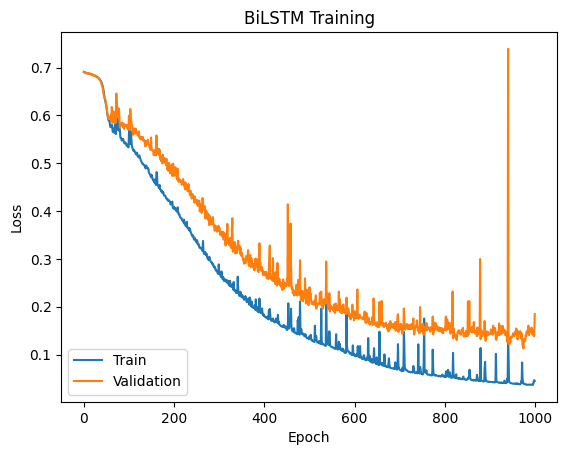

In [90]:
plt.plot(train_losses_cnn_01OVL, label="Train")
plt.plot(val_losses_cnn_01OVL, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [91]:
y_true_flat,y_pred_flat=evaluate(best_model_cnn_01OVL,test_loader_01OVL)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.93      0.95      0.94     17330
   Eyes open       0.94      0.92      0.93     14414

    accuracy                           0.94     31744
   macro avg       0.94      0.93      0.94     31744
weighted avg       0.94      0.94      0.94     31744



In [92]:
optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr=1e-6)

best_model_cnn_01OVL_finetune,train_losses_cnn_01OVL_finetune, val_losses_cnn_01OVL_finetune = train_model(
    best_model_cnn_01OVL,
    train_loader_01OVL,
    test_loader_01OVL,
    criterion,
    optimizer,
    10000,
    1000
)


Epoch 1: train=0.0470, val=0.1363
Epoch 2: train=0.0364, val=0.1476
Epoch 3: train=0.0363, val=0.1440
Epoch 4: train=0.0362, val=0.1375
Epoch 5: train=0.0358, val=0.1383
Epoch 6: train=0.0358, val=0.1367
Epoch 7: train=0.0357, val=0.1477
Epoch 8: train=0.0359, val=0.1360
Epoch 9: train=0.0356, val=0.1375
Epoch 10: train=0.0354, val=0.1410
Epoch 11: train=0.0356, val=0.1389
Epoch 12: train=0.0352, val=0.1374
Epoch 13: train=0.0352, val=0.1465
Epoch 14: train=0.0354, val=0.1507
Epoch 15: train=0.0351, val=0.1393
Epoch 16: train=0.0352, val=0.1407
Epoch 17: train=0.0352, val=0.1565
Epoch 18: train=0.0352, val=0.1433
Epoch 19: train=0.0351, val=0.1398
Epoch 20: train=0.0349, val=0.1411
Epoch 21: train=0.0349, val=0.1444
Epoch 22: train=0.0351, val=0.1502
Epoch 23: train=0.0350, val=0.1423
Epoch 24: train=0.0349, val=0.1425
Epoch 25: train=0.0349, val=0.1443
Epoch 26: train=0.0345, val=0.1419
Epoch 27: train=0.0349, val=0.1419
Epoch 28: train=0.0347, val=0.1507
Epoch 29: train=0.0345, val=0

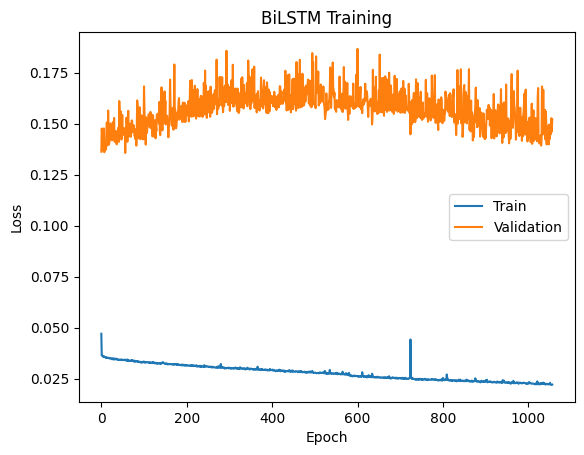

In [93]:
plt.plot(train_losses_cnn_01OVL_finetune, label="Train")
plt.plot(val_losses_cnn_01OVL_finetune, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [94]:
y_true_flat,y_pred_flat=evaluate(best_model_cnn_01OVL_finetune,test_loader_01OVL)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.96      0.96      0.96     17330
   Eyes open       0.95      0.95      0.95     14414

    accuracy                           0.96     31744
   macro avg       0.96      0.96      0.96     31744
weighted avg       0.96      0.96      0.96     31744



In [84]:
train_loader_4sec_01OVL,test_loader_4sec_01OVL= create_loader(eeg_normalized,target,128*4,0.1)

torch.Size([284, 512, 10])
torch.Size([284, 512])


In [85]:
model = BiLSTM(n_channels=10, hidden_size=64).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
best_model_4sec_01OVL,train_losses_4sec_01OVL, val_losses_4sec_01OVL = train_model(
    model,
    train_loader_4sec_01OVL,
    test_loader_4sec_01OVL,
    criterion,
    optimizer,
    1000,
    100
)


Epoch 1: train=0.6927, val=0.6926
Epoch 2: train=0.6921, val=0.6913
Epoch 3: train=0.6925, val=0.6927
Epoch 4: train=0.6917, val=0.6913
Epoch 5: train=0.6920, val=0.6917
Epoch 6: train=0.6916, val=0.6926
Epoch 7: train=0.6920, val=0.6909
Epoch 8: train=0.6922, val=0.6923
Epoch 9: train=0.6921, val=0.6928
Epoch 10: train=0.6923, val=0.6928
Epoch 11: train=0.6920, val=0.6913
Epoch 12: train=0.6910, val=0.6918
Epoch 13: train=0.6920, val=0.6911
Epoch 14: train=0.6914, val=0.6917
Epoch 15: train=0.6911, val=0.6917
Epoch 16: train=0.6919, val=0.6913
Epoch 17: train=0.6919, val=0.6910
Epoch 18: train=0.6917, val=0.6908
Epoch 19: train=0.6916, val=0.6902
Epoch 20: train=0.6903, val=0.6920
Epoch 21: train=0.6902, val=0.6928
Epoch 22: train=0.6911, val=0.6909
Epoch 23: train=0.6906, val=0.6912
Epoch 24: train=0.6903, val=0.6904
Epoch 25: train=0.6903, val=0.6908
Epoch 26: train=0.6897, val=0.6899
Epoch 27: train=0.6916, val=0.6898
Epoch 28: train=0.6907, val=0.6911
Epoch 29: train=0.6907, val=0

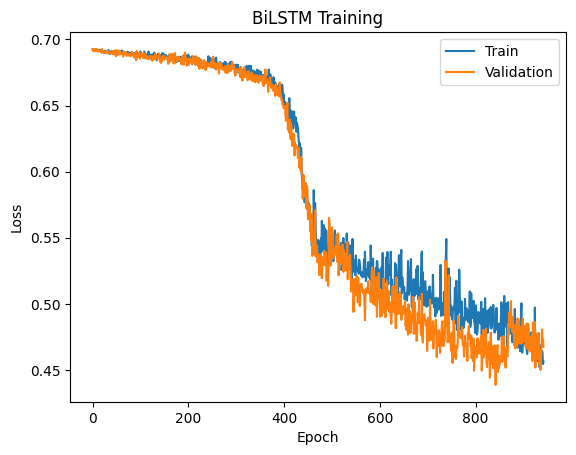

In [86]:
plt.plot(train_losses_4sec_01OVL, label="Train")
plt.plot(val_losses_4sec_01OVL, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [87]:
y_true_flat,y_pred_flat=evaluate(best_model_4sec_01OVL,test_loader_4sec_01OVL)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.76      0.86      0.81     15736
   Eyes open       0.81      0.69      0.75     13448

    accuracy                           0.78     29184
   macro avg       0.79      0.78      0.78     29184
weighted avg       0.79      0.78      0.78     29184

